# Level 2: Global Frog Discovery Tool benchmark notebook

## Challenge Level 2 Overview

Welcome to the 2022 EY Data Science Challenge! This is the second challenge aimed at intermediate and advanced participants that have some level of experience in data science and programming. For less experienced participants, we recommend undertaking challenge level 1 outlined [here](Model_Level_1.ipynb). If you choose to undertake the second level of the challenge, you will be developing a species distribution model (SDM) for 9 selected frog species across Australia, Costa Rica, and South Africa using a variety of open-source geospatial datasets. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The 9 frog species identified for this challenge were hand picked by frog experts as being species of most concern for conservation efforts. In addition to assisting our understanding of these specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

**Challenge aim:** to develop a species distribution model for 9 frog species across Australia, Costa Rica, and South Africa using a variety of open-source geospatial datasets.



| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|1    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|***2***     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 9 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |


In this notebook, we will demonstrate a complex model workflow that can form a basis for developing a comprehensive solution to the challenge. As specified in the third row of the table above, this model will be trained on three international regions at the finest spatial resolution (10m x 10m), predicting all 9 target species. The model will be trained with all of the available data sources explored in the supplementary notebooks provided for the challenge, namely [TerraClimate](https://planetarycomputer.microsoft.com/dataset/terraclimate), [Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a), [Land Cover](https://planetarycomputer.microsoft.com/dataset/group/io-land-cover), [JRC Global Surface Water](https://planetarycomputer.microsoft.com/dataset/jrc-gsw), and [Copernicus Digital Elevation](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30). We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period. 

Most of the functions present in this notebook were adapted from the following notebooks:
- [Training Dataset Summary](supplementary_notebooks/dataset_summary.ipynb)
- [TerraClimate/Weather](supplementary_notebooks/TerraClimate.ipynb)
- [Sentinel-2](supplementary_notebooks/Sentinel-2.ipynb)
- [Land Cover](supplementary_notebooks/Esri_Land_Cover.ipynb)
- [JRC Global Surface Water](supplementary_notebooks/JRC_Surface_Water.ipynb)
- [Copernicus Digital Elevation](supplementary_notebooks/Copernicus_DEM.ipynb)

It must be noted that this notebook is just a starting point. We make plenty of assumptions in this notebook that you may not think are best for solving the challenge effectively. You are encouraged to modify these functions, to rewrite them completely, or to try a different approach entirely.


## Load in dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take a while. 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
from itertools import cycle

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Image processing
from scipy.ndimage import convolve

# Geospatial
from shapely.geometry import Point, Polygon
import xarray as xr
import zarr # Not referenced, but required for xarray
import rasterio
import rasterio.features
import rioxarray as rio
import contextily as cx

# For TerraClimate
import fsspec

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
import gc
import zipfile

# Folder to store extracted files
storage_path = './output/'
if not os.path.exists(storage_path):
    os.mkdir(storage_path)

# Path to data folder with provided material
data_path = '../'

## Jupyter Memory

For any advanced workflow, it is essential that you have enough memory allocated to Jupyter to facilitate high volume data processing. Our recommended VM deployment should have JupyterHub already configured to utilise all available memory resources. If you are using a different environment, you should follow the relevant documentation online to ensure your notebook environment can handle the large workflows we will be exploring. 

The most memory intensive component of the challenge will be processing the Sentinel-2 satellite data due to its high spatial and temporal resolution. 8GB of memory should be enough to run this specific demonstration notebook, but we would recommend allocating the majority of your RAM especially when you are collecting and processing your own training and testing data.

In the demonstration notebook, we downsample the predictor variables to 100m resolution to make it more managable to run. The finest resolution possible is 10m (the same resolution as Sentinel-2). If you attempt this finer resolution, be aware of the memory and time resources required. We recommend all participants think carefully about how to optimise the data pipeline to minimise i/o from the planetary computer, especially at finer resolutions. Reading a local geotiff file is much quicker than pulling from the planetary computer directly, and can be much less memory intensive too due to xarray's lazy loading capabilities.

This notebook contains a few helper functions and techniques to assist with memory optimisation. These involve:
- subsampling the training set into smaller regions that are more managable to load satellite data for,
- loading regions in piece by piece rather than all at once,
- filtering sentinel-2 scenes on their metadata first,
- saving processing products to file to avoid re-running processing operations every time,
- clearing variables with the `del` key if they are no longer in use,
- optimising your processing code with xarray to minimise memory usage


Here are some notes on Jupyter and how it handles memory. These may come in handy when troubleshooting:
- **The kernel will die when it runs out of memory**, without explicitly prompting you that it is a memory issue. If you find you are having to restart your kernel when running a certain cell, it is likely that you have exceeded the memory allocation for Jupyter.
- Even if your code is memory-optimised and is not saving large datasets to variable names, sometimes Jupyter contains hidden pointers to these objects which can hog memory. For this reason, it is sometimes necessary to **restart the kernel after large processing operations** and load in the resultant data from file. This should free up any stranded memory.
- Sometimes runtime errors are thrown during long computational steps, and other times files from the planetary computer will fail to be read. These errors are not always the fault of the programmer, and often all that is needed to fix the error is to re-run the exact same code again. Restarting the kernel may also solve the issue.


To monitor the kernel's memory usage, consider using commands such as `htop` in the VM's terminal.

## Response Variable

Before we can build our model, we need to load in the response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [3]:
all_frog_data = get_frogs(data_path+'training_data/occurrence.txt')
all_frog_data.sample(10, random_state=420)

gbifID  eventDate    country        continent  \
163312  2816174271 1969-07-16     Panama  Central America   
104013  1642942453 1992-07-09  Australia        Australia   
60280   3463541394 2020-01-23  Australia        Australia   
47654   3463621035 2020-11-06  Australia        Australia   
59224   3463501651 2020-06-19  Australia        Australia   
106863  1066549925 1977-09-04  Australia        Australia   
64657   3463554118 2020-06-17  Australia        Australia   
78046   3463484019 2020-02-08  Australia        Australia   
63899   3463534364 2018-06-28  Australia        Australia   
41686   3463698529 2020-11-09  Australia        Australia   

                       stateProvince  decimalLatitude  decimalLongitude  \
163312                        Panamá         9.151880        -79.618800   
104013                      Victoria       -38.210530        142.030000   
60280                New South Wales       -33.325000        151.364000   
47654   Australian Capital Territory       -35.389100        149.131000   
59224                       Victoria       -37.984500        144.521000   
106863                      Victoria       -36.566667        146.133333   
64657              Western Australia       -31.936500        115.892000   
78046                     Queensland       -27.452332        153.067139   
63899                New South Wales       -33.111800        151.646000   
41686                South Australia       -34.800198        138.783951   

                      species  
163312  Agalychnis Callidryas  
104013       Crinia Signifera  
60280          Litoria Fallax  
47654        Crinia Signifera  
59224        Crinia Signifera  
106863       Crinia Signifera  
64657         Crinia Glauerti  
78046          Litoria Fallax  
63899        Crinia Signifera  
41686        Crinia Signifera

The training dataset contains occurrences for neighbouring countries in Central America and Africa, but for this demonstration we will only focus on the countries of interest for this challenge, Australia, Costa Rica, and South Africa. 

In [4]:
# Take only Australia, Costa Rica, and South Africa
frog_data = all_frog_data[all_frog_data.country.str.contains('Australia|Costa Rica|South Africa')]

Below we define some functions to assist in plotting the frog data. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

In [5]:
# Define species colourmap
species_colourmap = {species:colour['color'] for species, colour in zip(all_frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}

def plot_species(fig, ax, frog_data, region_name, colourmap=None):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    if colourmap is None:
        colourmap = {species:colour['color'] for species, colour in zip(frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
    for i in range(len(bar_data)):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(colourmap[species_name])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=colourmap[species_name]
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
def plot_barchart(bar_data, ax, colourmap=None, bar_params={}):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    if colourmap is None:
        prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
        colourmap = {spec:col['color'] for spec, col in zip(bar_data.index, prop_cycle)}
    for i in range(len(bar_data)):
        var_name = bar_data.index[i]
        barchart[i].set_color(colourmap[var_name])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Below, we can visualise the frog species distribution of each country. 

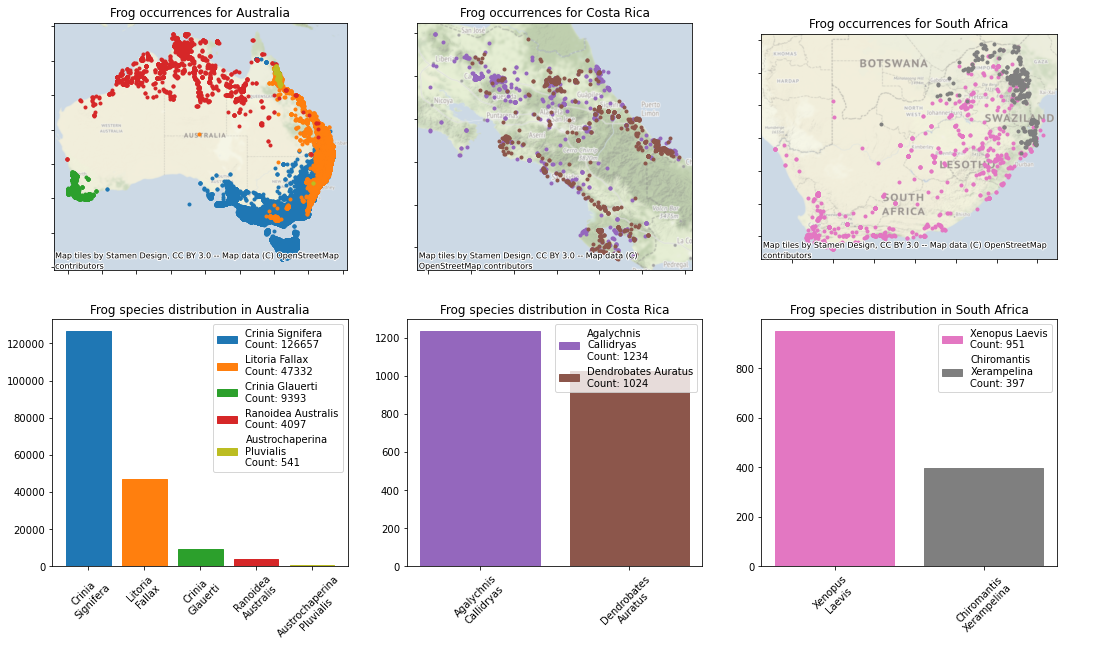

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
for i, cnt in enumerate(frog_data.country.unique()):
    plot_species(fig, ax[:, i], frog_data[frog_data.country == cnt], cnt, colourmap=species_colourmap)
plt.show()


### Spatial sampling

Due to the high resolution of the satellite data we aim to use in this challenge, the memory required to load in data for any significant region quickly becomes overbearing. Thus, it is only feasible to load in satellite data for small regions at a time. To cover the entire dataset, we would need to load in the satellite data in small chunks of around 50km by 50km (depending on the specs of your computer).

While theoretically possible, it may be unfeasible to load in the entire region covered by the dataset piece by piece. Instead, you may have to develop a smart way of subsampling the dataset into several smaller geographic locations from each country. This would involve taking care to ensure each species is well represented in numbers and that the extent of the variation in their habitat is also captured. 

In this demonstration notebook, we will choose one region from each country. In doing this, we will miss many of the 15 species we wish to model. It is probably a good idea to add extra regions to this list to capture those species that are more region-specific. How well you are able to subsample the dataset will impact your model's performance. The folium interactive map made in the training data supplementary notebook may be able to assist with finding regions.


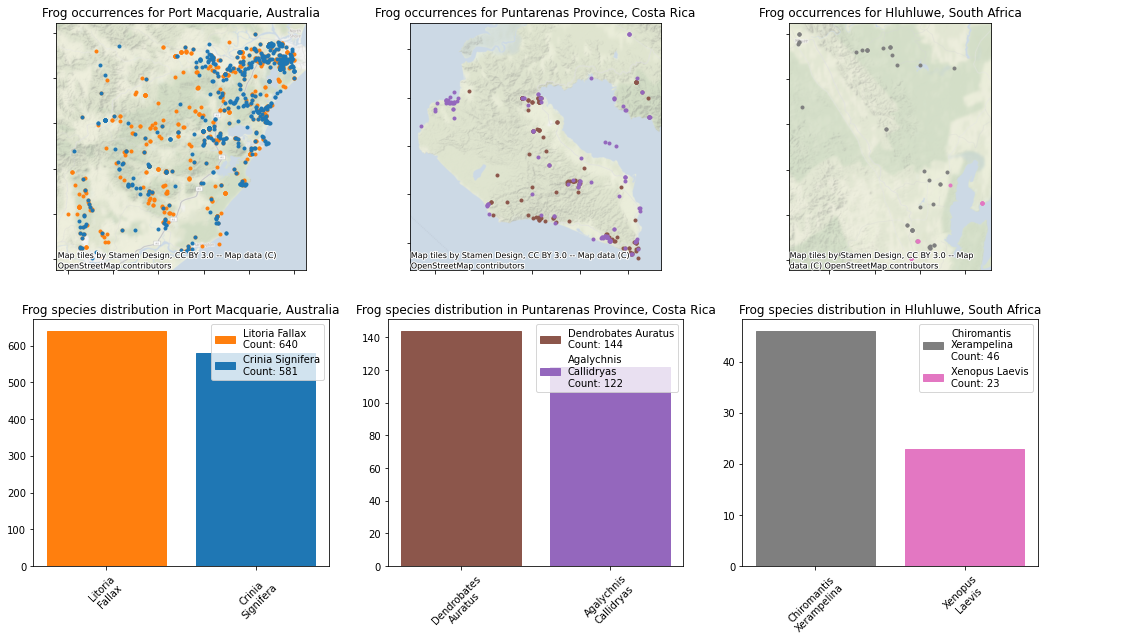

In [7]:
training_regions = {
    'Australia':[
        {'title':"Port Macquarie, Australia", 
         'bbox':(152.4, -31.9, 152.9, -31.4)}
    ],
    'Costa Rica':[
        {'title':"Puntarenas Province, Costa Rica",
        'bbox':(-83.75,8.35,-83.25,8.85)}
    ],
    'South Africa':[
        {'title':"Hluhluwe, South Africa",
        'bbox':(32.00,-28.1,32.50,-27.6)}
    ]
}
training_data = pd.DataFrame()

fig, ax = plt.subplots(2, 3, figsize=(18, 10))
for i, (cnt, boxes) in enumerate(training_regions.items()):
    plot_data = pd.DataFrame()
    for box in boxes:
        plot_data = plot_data.append(filter_bbox(frog_data, box['bbox']))
    training_data = training_data.append(plot_data)
    plot_species(fig, ax[:, i], plot_data, box['title'], colourmap=species_colourmap)
plt.show()

### Sampling bias

The scatter plots above show that the data are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This inherent sampling bias is common in citizen science and is a key issue to address for success in this challenge. If this bias is not accounted for in model training, the model may also be biased towards urban areas reducing its effectiveness as a species distribution model.


There are many ways that this bias may be addressed. For example, you may want to develop a smart way of sampling where frogs aren't, noting that just picking a random point where there are no frog occurrences will not guarantee that there are actually no frogs in that location. Another method is to focus on predicting each species independently, and to use the occurrence points of other species as absence points. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. The latter method is what we will showcase in this demonstration notebook. 


### Class balancing

Another issue shown clealy in the barcharts above is the class imbalance of the frog species. While we have only picked a region in Australia with two species present, the distribution of the other three Australian species is far from uniform. This bias should be addressed in some capacity before model training, otherwise the model could become biased towards the more common species.

For this demonstration, we will address this by down-sampling the common species and up-sampling the rarer species so that their counts are comparable. This is quite a naive approach, so you are encouraged to pursue other more thoughtful ways of addressing this issue. One potential avenue is to perform augmentation when up-sampling the rarer frogs.

Text(0.5, 1.0, 'Balanced training set')

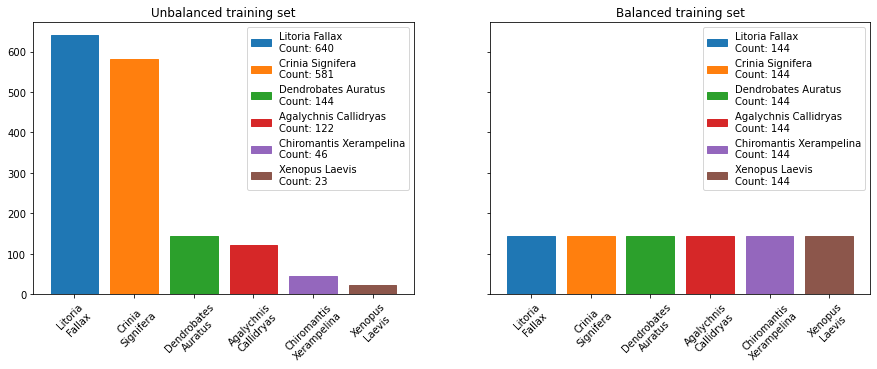

In [8]:
bar_data = training_data.species.value_counts()

# Set target frequency to be the third most common species
target_counts = bar_data[2]

balanced_frogs = pd.DataFrame()

for species, counts in zip(bar_data.index, bar_data):
    balanced_frogs = balanced_frogs.append(
        training_data
        [lambda x: x.species == species]
        .sample(target_counts, random_state=420, replace=True)
    )
# Reassign key for joining
balanced_frogs = balanced_frogs.reset_index(drop=True).assign(key = lambda x: x.index)
    
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
balanced_bar_data = balanced_frogs.species.value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

### Temporal sampling

In addition to spatial sampling, temporal sampling may also be worth considering. While there may have been frog sightings in a certain region, are these frog sightings recent? If a region has many sightings from say 100 years ago but none since, does it still make sense to use this region in training? Each predictor dataset will have a different temporal range, so sometimes the most up-to-date data will not be available for older frog observations. In these cases, you should consider how far back each dataset will remain representative. For example, the satellite data we will use only dates back to 2015, so how far in the past does the satellite data remain representative of the actual terrain? This might depend on the band and/or index. Alternatively, you could simply ignore the temporal component and assume that frogs do not move very far over time, or choose a sensible timeframe for which this assumption remains reasonable. This is the approach we will take for this demonstration notebook.

### Final training data

After balancing the classes, we finally have our training data. Some areas to optimise include:
- Spatial sampling - choosing more regions that are representative of the entire dataset.
- Sampling bias - developing a smart way to address the dataset's bias towards urban areas.
- Class balancing - smarter up-sampling and down-sampling methods using techniques like data augmentation to increase the representation of rarer species. 
- Temporal sampling - considering the temporal component of the dataset. Which older points are still relevant, and which may not be?

Since we will be using this training dataset for evaluation, the evaluation metrics will contain bias due to our naive approaches to addressing each of the above issues. You are encouraged to improve the training set collection process until you are confident in its ability to accurately train and evaluate your model. For now, we will continue with this training set.

## Predictor Variables

Now that we have sub-sampled a training set composed of regions of a manageable size, we can join on the predictor variables. The TerraClimate data is accessed in a slightly different way to the rest of the datasets, so we will need to handle it separately to the others. We do this in the following section, before moving on to the four remaining datasets. 

### TerraClimate

The first dataset we will be pulling from is TerraClimate. This contains information on weather variables. You can learn more about this dataset and the code we use to extract it in the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb).

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take six metrics from four assets, namely the mean and overall maximum monthly air temp (`tmax_mean`, `tmax_max`), mean and overall minimum monthly air temp (`tmin_mean`, `tmin_min`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a seven year timeframe from the start of 2015 to the end of 2021 (to align with the date range of Sentinel-2). A reminder that we are currently ignoring the temporal component of the response variable, so we are assuming this timeframe is representative of all frog observations regardless of date.


In [9]:
def get_terraclimate(bbox, filename=None, metrics={'mean':{'fn':np.nanmean,'params':{}}}, 
                     time_slice=None, assets=None, features=None, interp_dims=None, verbose=False):
    """Returns terraclimate metrics for a given area (or None if filename specified), allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    filename -- string or None. If None, will save result to geotiff. 
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
            
    # Calculate metrics
    combined_data = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        sum_data = sum_data.assign_coords(band = [band+'_'+name for band in sum_data.band.values])
        combined_data.append(sum_data)
        
    # Combine metrics
    combined_data = xr.concat(combined_data, dim='band')
    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
        
    if filename is not None:
        save_to_geotiff(combined_data, filename, bbox)
        return None
    
    return combined_data

### Sentinel-2

Sentinel-2 is the first of four datasets that we will pull using the same core function `get_pc`, which will be defined later. The Sentinel-2 data is particularly memory intensive due to its high spatial and temporal resolution. For this reason we will define some basic memory optimisation helper functions below to assist with memory and computational time when querying the planetary computer. This functionality could also be applied to other products if the query bounding box is sufficiently large to cause issues.

<!-- It will calculate the median mosaic over the time dimension of each product, which will only be relevant to products that return multiple scenes over time such as the Sentinel-2 data. -->

We have implemented the following two functionalities as quick solutions to memory optimisation. Other avenues may be necessary to explore if your workflow reaches the extent of your computing constraints.
- `split_bbox` splits the bounding box into pieces, enabling us to load the Sentinel-2 data piece by piece. Use greater than (1, 1) if memory is tight.
- `get_optimal_coverage` filters the scenes using their bounding box contained in their metadata. This allows us to only take enough scenes to cover the entire bounding box (as the planetary computer returns all scenes that merely intersect with the region). This technique of filtering scenes on their metadata rather than loading them in and filtering them in xarray is a useful avenue to reduce the load time and memory requirements of Sentinel-2 data.


In [10]:
def split_bbox(bbox, n_x, n_y):
    """Splits bounding box into n_x columns and n_y rows"""
    lons = np.linspace(bbox[0],bbox[2], n_x+1)
    lats = np.linspace(bbox[1],bbox[3], n_y+1)
    boxes = []
    for i in range(len(lons)-1):
        for j in range(len(lats)-1):
            boxes.append((lons[i], lats[j], lons[i+1], lats[j+1]))
    return boxes

def scene_overlap(signed_item, bbox_poly):
    """Returns the polygon of the bounding box not covered by the scene"""
    scene_poly = Polygon(signed_item['geometry']['coordinates'][0])
    return bbox_poly.difference(scene_poly)

def get_optimal_coverage(signed_items, bbox, sortby='s2:nodata_pixel_percentage',
                         reverse=False, target_coverage=1.0, scenes_per_hit=1, verbose=False):
    signed_items = sorted(signed_items, key=lambda x: x['properties'][sortby], reverse=reverse)

    bbox_poly = Polygon([
        [bbox[0], bbox[1]],
        [bbox[0], bbox[3]],
        [bbox[2], bbox[3]],
        [bbox[2], bbox[1]],
        [bbox[0], bbox[1]]
    ])
    take_items = []
    remaining_area = Polygon(bbox_poly)
    remaining_area_prev = Polygon(bbox_poly)
    for i, item in enumerate(signed_items):
        remaining_area = Polygon(scene_overlap(item, remaining_area_prev))
        # If item hits new area, take it.
        new_coverage = remaining_area_prev.difference(remaining_area).area/bbox_poly.area
        if new_coverage > 0.0:
            take_items.append(item)
            n_scenes = 1
        else:
            if n_scenes < scenes_per_hit:
                take_items.append(item)
                n_scenes += 1

        # If remaining area is less than the <optimise_coverage> threshold, break
        total_coverage = 1 - remaining_area.area/bbox_poly.area
        if total_coverage >= target_coverage: 
            for j in range(1, scenes_per_hit+1):
                if i+j < len(signed_items):
                    take_items.append(signed_items[i+j])
            if verbose:
                print(f'Covered {round((total_coverage)*100, 2)}% with {len(take_items)} scenes')
                print(f'Searched {min(i+scenes_per_hit, len(signed_items))} scenes')
            break
        remaining_area_prev = Polygon(remaining_area)
    else:
        print(f'Only covered {round((total_coverage)*100, 2)}% with {len(take_items)} scenes')
        print(f'Consider refining query parameters')
    signed_items = take_items
    
    return signed_items

### Elevation (Copernicus DEM)

The next dataset we will be loading in is the Copernicus Digital Elevation Model (DEM) to obtain elevation data for our training regions. In addition to elevation, we will calculate the slope from the elevation data. To do this, we define the `slope_pct` function to apply over the elevation data. Further information on this dataset can be found in the relevant [supplementary notebook](supplementary_notebooks/Copernicus_DEM.ipynb).



In [11]:
def slope_pct(dem, resolution):
    # Kernel for rate of elevation change in x-axis.
    dx_kernel = np.array([[1, 0, -1],
                          [2, 0, -2],
                          [1, 0, -1]])
    # Kernel for rate of elevation change in y-axis.
    dy_kernel = np.array([[1, 2, 1],
                          [0, 0, 0],
                          [-1, -2, -1]])
    # Rate of change calculations for each axis.
    dx = convolve(dem, dx_kernel) / (8 * resolution)
    dy = convolve(dem, dy_kernel) / (8 * resolution)
    # Return rise/run * 100 for slope percent.
    return np.sqrt(np.square(dx) + np.square(dy)) * 100

### Land Cover (Esri)

The Esri Land Cover dataset contains categorical labels for each pixel on the type of terrain. The categories are encoded as integers from 1 to 10, and so will need to be translated to make sense for our model. We will translate the landcover values into one-hot encoding, where each category will have a binary mask of presence and absense. To do this, we define the categorical mapping below, taken from the [Esri Land Cover documentation.](https://planetarycomputer.microsoft.com/dataset/io-lulc)

In [12]:
landcover_mapper = {
    1:  'lc_water', 
    2:  'lc_trees', 
    3:  'lc_grass',
    4:  'lc_flooded_vegetation', 
    5:  'lc_crops',
    6:  'lc_scrub', 
    7:  'lc_urban', 
    8:  'lc_bare_soil',
    9:  'lc_snow_ice', 
    10: 'lc_clouds'
}

### Surface Water (JRC)

The JRC dataset contains six variables: change, extent, occurrence, recurrence, seasonality, and transitions. The last variable, transitions, is actually a categorical variable similar to Land Cover above. It relates to the change in surface water status from 1984 to 2020. The categorical mapping is defined below as described in the [JRC documentation](https://planetarycomputer.microsoft.com/dataset/jrc-gsw).

In [13]:
JRC_transitions_mapper = {
    1:  "JRC_tr_permanent", 
    2:  "JRC_tr_new_permanent", 
    3:  "JRC_tr_lost_permanent", 
    4:  "JRC_tr_seasonal", 
    5:  "JRC_tr_new_seasonal", 
    6:  "JRC_tr_lost_seasonal", 
    7:  "JRC_tr_seasonal_to_permanent", 
    8:  "JRC_tr_permanent_to_seasonal", 
    9:  "JRC_tr_ephemeral_permanent", 
    10: "JRC_tr_ephemeral_seasonal"
}

### Loading variables

While TerraClimate has a separate loading function, the remaining datasets can all be accessed through the same loading function called `get_pc`. This function is flexible enough to facilitate the different parameters needed to load each dataset. We define this function below.

In [14]:
# Function to access the planetary computer
def get_pc(product, bbox, filename=None, assets={"image/tiff"}, resolution=10, 
           pc_query=None, date_range=None, na_val=None, optimise_coverage_params=None, verbose=True):
    """Return the median mosaic xarray of a specified planetary computer product for a given location
    
    Attributes:
    product -- string representing the planetary computer product
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    assets -- list of assets to take from the product
    resolution -- resolution in meters
    pc_query -- dictionary of arguments to pass to the planetary computer
    date_range -- string representing the date range of the query e.g. '2020-01-01/2020-12-31'
    na_val -- the value representing na values in the dataset. Will be ignored in median calculation
    filename -- string or None. If None, will save result to geotiff.
    """
    # Query the planetary computer
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print(f'{len(items)} scenes touching region') if verbose else None
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    
    if optimise_coverage_params is not None:
        signed_items = get_optimal_coverage(signed_items, bbox, verbose=verbose, **optimise_coverage_params)
    
    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    if na_val is not None:
        data = data.where(lambda x: x != na_val, other=np.nan)
        
    # Median Composite
    median = data.median(dim="time", skipna=True)
    
    # Rename bands of those with only one band (which otherwise defaults to generic 'data')
    if median.shape[0] == 1:
        median = median.assign_coords(band=[product])
    
    if filename is not None:
        save_to_geotiff(median, filename, bbox)
        return None
    
    return median

Finally, we put all these functions together in a single `get_and_join_data` function. This function will take in our response variable and join on each of the predictor variables from the planetary computer. A helper function of `join_frogs` assists us in joining the satellite data on to each frog coordinate.

In [15]:
def join_frogs(bbox, data, frogs, verbose=False):
    intersecting_frogs = (
        frogs
        [lambda x: 
         (x.decimalLongitude >= bbox[0]) &
         (x.decimalLatitude >= bbox[1]) &
         (x.decimalLongitude <= bbox[2]) &
         (x.decimalLatitude <= bbox[3])
        ]
    )
    if len(intersecting_frogs) > 0:
        print('merging frogs') if verbose else None
        frogs = frogs.merge(
            (
                data
                .sel(
                    x=xr.DataArray(intersecting_frogs.decimalLongitude, dims="key", coords={"key": intersecting_frogs.key}), 
                    y=xr.DataArray(intersecting_frogs.decimalLatitude, dims="key", coords={"key": intersecting_frogs.key}),
                    method="nearest"
                )
                .to_dataframe()
                .assign(val = lambda x: x.iloc[:, -1])
                [['val']]
                .reset_index()
                .drop_duplicates()
                .pivot(index="key", columns="band", values="val")
                .reset_index()
            ),
            on = ['key'],
            how = 'inner'
        )[list(data.band.values) + ['key']]
        return frogs
    else:
        return pd.DataFrame(columns=list(data.band.values) + ['key'])
        
def get_and_join_data(products, bbox, all_frogs, split_sen=(10, 10), verbose=False):
    """collect and download all products"""
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}')
        if product == 'sentinel-2-l2a':
            sen_frogs = pd.DataFrame()
            for box_num, box in enumerate(split_bbox(bbox, split_sen[0], split_sen[1])):
                print(f'fetching box {box_num+1} of {split_sen[0]*split_sen[1]}') if verbose else None
                data = get_pc(product, box, verbose=verbose, **params)
                sen_frogs = sen_frogs.append(join_frogs(box, data, all_frogs))
            all_frogs = all_frogs.merge(
                sen_frogs,
                on='key',
                how='left'
            )
            del sen_frogs
        else:
            # Interpolate the weather data to 10m resolution
            if product == 'terraclimate':
                data = get_terraclimate(bbox, verbose=verbose, **params)
            else:
                data = get_pc(product, bbox, verbose=verbose, **params)
            # Calculate the gradient of the elevation data
            if product == 'cop-dem-glo-30':
                data_elevation = data.squeeze().drop("band")
                slope_vals = slope_pct(data_elevation, products[product]['resolution'])
                data_slope = xr.DataArray(
                    np.expand_dims(slope_vals, 0),
                    coords=dict(
                        band=['gradient'],
                        y=data_elevation.y,
                        x=data_elevation.x
                    )
                )
                data = xr.concat((data, data_slope), dim='band')
                # remove elevation data from memory
                del data_slope, data_elevation, slope_vals
            all_frogs = all_frogs.merge(
                join_frogs(bbox, data, all_frogs, verbose=verbose),
                on='key',
                how='left'
            )
    return all_frogs

Each product requires different parameters. The Sentinel-2 parameters are particularly important as they greatly influence the computational resources required to load in the query. They will also influence the chance that clouds make their way into the median mosaic - lowering the 'eo:cloud_cover' filter will result in clearer scenes, but can result in certain areas of the region not being covered by any scenes at all (resulting in patches of null values).

Some products may fail to return scenes for certain regions, resulting in null values. Below, we create a summary table to display the percentage of occurrences that don't have null values. For the regions we have chosen, only 1% of the Costa Rica occurrences have null values for TerraClimate data. Because this is such a small number, we simply discard these occurrences.

Please check out the supplementary notebooks for each product to see how to visualise them. This is an important process to find the appropriate parameters for each product such that the datasets are quality for each training region.

**Note:** For this benchmark notebook, we use a resolution of 100m, given by the `resolution` variable. The finest resolution possible is that of sentinel-2 which is 10m. It is possible to run this notebook using 10m resolution by setting `resolution=10`, but this takes significantly more time and computational resources. Alternatively, if you are struggling to run the notebook with 100m resolution, try running it with `resolution=1000`. 

In [16]:
%%time

resolution = 100 # in meters. Finest = 10m

# Define products and query parameters for the planetary computer
products = {
    # Land Cover
    "io-lulc":{
        "resolution":resolution
    },
    # Elevation
    "cop-dem-glo-30":{
        "resolution":resolution
    },
    # Water extent data
    'jrc-gsw':{
        "resolution":resolution
    },
    # Sentinel-2 Spectral Band data
    'sentinel-2-l2a':{
        "resolution":resolution,
        'assets':["B04", "B03", "B02", "B08"], # Bands to take
        'pc_query':{
            "eo:cloud_cover": {"lt": 15} # Lower means clearer scenes, but may filter out all scenes for certain parts of the region.
        },
        'date_range':'2015-01-01/2020-12-31',
        # Take minimum scenes to cover entire area
        'optimise_coverage_params':{
            'sortby':'s2:nodata_pixel_percentage',
            'reverse':False,
            'target_coverage':1.0, # Proportion of scene to cover
            'scenes_per_hit':1 # With a few extra in case of clouds
        },
        'na_val':0
    },
    # Weather - might need to adjust x_dim, y_dim params to match dimensions of dataarrays above. Off by one errors common.
    "terraclimate":{
        'metrics':{
            'mean':{
                'fn':np.nanmean,
                'params':{}
            },
            'min':{
                'fn':np.nanmin,
                'params':{}
            },
            'max':{
                'fn':np.nanmax,
                'params':{}
            }
        },
        'time_slice':('2015-01-01','2019-12-31'),
        'assets':['tmax', 'tmin', 'ppt', 'soil'],
        'features':['tmax_max', 'tmax_mean', 'tmin_min', 'tmin_mean', 'ppt_mean', 'soil_mean']
    }
}

product_names={"cop-dem-glo-30":'elevation', "io-lulc":'landcover', 'jrc-gsw':'surface_water', 'sentinel-2-l2a':'sentinel-2'} 

# Load in data - comment out if already run
model_data = pd.DataFrame()
for cnt, regions in training_regions.items():
    print(f"Obtaining data for {cnt}")
    for i, region in enumerate(regions):
        print(f"{region['title']} ({i+1} of {len(regions)})")
        model_data = model_data.append(
            get_and_join_data(
                products, region['bbox'], filter_bbox(balanced_frogs, region['bbox']),
                split_sen=(1, 1), verbose=True
            )
        )
model_data = model_data.rename(columns=product_names)
model_data.to_csv(storage_path+f'training_{resolution}m.csv', index=None)

# Load in from file
model_data = pd.read_csv(storage_path+f'training_{resolution}m.csv')

# Display percentage of null values for each variable by country
print('Percentage of null values for each variable by country:')
display(
    np.divide(
        model_data.isna().join(model_data[['country']], lsuffix='_').groupby('country').sum(), 
        model_data.groupby('country').count()[['gbifID']]
    ).drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species', 'country_', 'key'], 1)*100
)

# Drop rows with NAs
model_data = model_data.dropna()
print('Model data:')
display(model_data)

Obtaining data for Australia
Port Macquarie, Australia (1 of 1)
loading io-lulc
2 scenes touching region
merging frogs
loading cop-dem-glo-30
1 scenes touching region
merging frogs
loading jrc-gsw
1 scenes touching region
merging frogs
loading sentinel-2-l2a
fetching box 1 of 1
446 scenes touching region
Covered 100.0% with 3 scenes
Searched 104 scenes
loading terraclimate
Loading data
Calculating mean
Calculating min
Calculating max
merging frogs
Obtaining data for Costa Rica
Puntarenas Province, Costa Rica (1 of 1)
loading io-lulc
3 scenes touching region
merging frogs
loading cop-dem-glo-30
1 scenes touching region
merging frogs
loading jrc-gsw
1 scenes touching region
merging frogs
loading sentinel-2-l2a
fetching box 1 of 1
88 scenes touching region
Covered 100.0% with 3 scenes
Searched 2 scenes
loading terraclimate
Loading data
Calculating mean
Calculating min
Calculating max
merging frogs
Obtaining data for South Africa
Hluhluwe, South Africa (1 of 1)
loading io-lulc
2 scenes tou

continent  stateProvince  landcover  elevation  gradient  \
country                                                                  
Australia           0.0       0.000000        0.0        0.0       0.0   
Costa Rica          0.0       8.333333        0.0        0.0       0.0   
South Africa        0.0      36.805556        0.0        0.0       0.0   

              change  extent  occurrence  recurrence  seasonality  ...  B04  \
country                                                            ...        
Australia        0.0     0.0         0.0         0.0          0.0  ...  0.0   
Costa Rica       0.0     0.0         0.0         0.0          0.0  ...  0.0   
South Africa     0.0     0.0         0.0         0.0          0.0  ...  0.0   

              B03  B02  B08  tmax_max  tmax_mean  tmin_min  tmin_mean  \
country                                                                 
Australia     0.0  0.0  0.0  0.000000   0.000000  0.000000   0.000000   
Costa Rica    0.0  0.0  0.0  1.388889   1.388889  1.388889   1.388889   
South Africa  0.0  0.0  0.0  0.000000   0.000000  0.000000   0.000000   

              ppt_mean  soil_mean  
country                            
Australia     0.000000   0.000000  
Costa Rica    1.388889   1.388889  
South Africa  0.000000   0.000000  

[3 rows x 21 columns]

Model data:


gbifID            eventDate       country  continent  \
0    3463644933  2020-03-04 00:00:00     Australia  Australia   
1    1070542281  2013-03-27 00:00:00     Australia  Australia   
2    3108856427  2019-09-22 00:00:00     Australia  Australia   
3    3108941946  2018-03-07 00:00:00     Australia  Australia   
4    3463533596  2020-02-09 00:00:00     Australia  Australia   
..          ...                  ...           ...        ...   
856  1671746657  2011-03-04 00:00:00  South Africa     Africa   
857  1671746657  2011-03-04 00:00:00  South Africa     Africa   
859  1839215098  2017-01-21 00:00:00  South Africa     Africa   
860  1671746657  2011-03-04 00:00:00  South Africa     Africa   
862  1671751438  2011-03-04 00:00:00  South Africa     Africa   

       stateProvince  decimalLatitude  decimalLongitude         species  key  \
0    New South Wales       -31.611400        152.711000  Litoria Fallax    0   
1    New South Wales       -31.520393        152.686680  Litoria Fallax    1   
2    New South Wales       -31.473372        152.781851  Litoria Fallax    2   
3    New South Wales       -31.443400        152.785000  Litoria Fallax    3   
4    New South Wales       -31.426100        152.845000  Litoria Fallax    4   
..               ...              ...               ...             ...  ...   
856    KwaZulu-Natal       -27.972370         32.437520  Xenopus Laevis  856   
857    KwaZulu-Natal       -27.972370         32.437520  Xenopus Laevis  857   
859    KwaZulu-Natal       -28.057353         32.294663  Xenopus Laevis  859   
860    KwaZulu-Natal       -27.972370         32.437520  Xenopus Laevis  860   
862    KwaZulu-Natal       -27.972370         32.437520  Xenopus Laevis  862   

     landcover  ...    B04    B03    B02     B08   tmax_max  tmax_mean  \
0          2.0  ...  198.5  344.5  141.5  3754.0  30.300003  24.531672   
1          2.0  ...  131.0  207.0   86.5  2591.0  30.099998  24.253336   
2          6.0  ...  315.5  355.0  203.0  2188.5  30.099998  24.476665   
3          7.0  ...  659.0  637.5  400.0  2314.0  30.200005  24.546667   
4          3.0  ...  465.5  490.0  264.0  2613.0  30.000000  24.366669   
..         ...  ...    ...    ...    ...     ...        ...        ...   
856        2.0  ...  281.0  425.5  222.0  2864.0  31.900002  28.096668   
857        2.0  ...  281.0  425.5  222.0  2864.0  31.900002  28.096668   
859        2.0  ...  438.0  496.0  327.0  2234.0  31.599998  28.003334   
860        2.0  ...  281.0  425.5  222.0  2864.0  31.900002  28.096668   
862        2.0  ...  281.0  425.5  222.0  2864.0  31.900002  28.096668   

      tmin_min  tmin_mean   ppt_mean   soil_mean  
0     6.300003  13.638333  100.01667  108.983330  
1     5.900002  13.143335  103.61667  112.383330  
2     6.200005  13.581668   97.78333  101.400000  
3     6.200005  13.555002   95.51667   97.900000  
4     6.500000  13.798335  102.48333  109.983330  
..         ...        ...        ...         ...  
856  12.599998  17.476667   68.36667   11.166667  
857  12.599998  17.476667   68.36667   11.166667  
859  12.300003  17.378336   72.75000   15.516666  
860  12.599998  17.476667   68.36667   11.166667  
862  12.599998  17.476667   68.36667   11.166667  

[725 rows x 28 columns]

CPU times: user 33.2 s, sys: 3.24 s, total: 36.4 s
Wall time: 4min 24s


### Recoding categorical variables

As mentioned above, the Land Cover data and the JRC data both contain categorical variables that need recoding for use in our model. The mappings are stored in `landcover_mapper` and `JRC_transitions_mapper` we defined earlier. Below we recode these variables into one-hot encoding, a binary mask for each class. This is necessary for certain models like logistic regression which we aim to use in this demonstration.

In [17]:
model_data = (
    model_data
    .merge(
        pd.get_dummies(
            model_data.landcover.astype(int).map(landcover_mapper)
        ).assign(key=model_data.key),
        on='key'
    )
    .drop("landcover", 1)
    .merge(
        pd.get_dummies(
            model_data.transitions.astype(int).map(JRC_transitions_mapper)
        ).assign(key=model_data.key),
        on='key'
    )
    .drop("transitions", 1)
)
model_data.head()

gbifID            eventDate    country  continent    stateProvince  \
0  3463644933  2020-03-04 00:00:00  Australia  Australia  New South Wales   
1  1070542281  2013-03-27 00:00:00  Australia  Australia  New South Wales   
2  3108856427  2019-09-22 00:00:00  Australia  Australia  New South Wales   
3  3108941946  2018-03-07 00:00:00  Australia  Australia  New South Wales   
4  3463533596  2020-02-09 00:00:00  Australia  Australia  New South Wales   

   decimalLatitude  decimalLongitude         species  key  elevation  ...  \
0       -31.611400        152.711000  Litoria Fallax    0  11.474139  ...   
1       -31.520393        152.686680  Litoria Fallax    1  99.564926  ...   
2       -31.473372        152.781851  Litoria Fallax    2  40.742161  ...   
3       -31.443400        152.785000  Litoria Fallax    3  32.177208  ...   
4       -31.426100        152.845000  Litoria Fallax    4   1.683177  ...   

   lc_scrub  lc_trees  lc_urban  lc_water  JRC_tr_lost_permanent  \
0         0         1         0         0                      0   
1         0         1         0         0                      0   
2         1         0         0         0                      0   
3         0         0         1         0                      0   
4         0         0         0         0                      0   

   JRC_tr_new_permanent  JRC_tr_new_seasonal  JRC_tr_permanent  \
0                     0                    0                 0   
1                     0                    0                 0   
2                     0                    0                 0   
3                     0                    0                 0   
4                     0                    0                 0   

   JRC_tr_seasonal  JRC_tr_seasonal_to_permanent  
0                0                             0  
1                0                             0  
2                0                             0  
3                0                             0  
4                0                             0  

[5 rows x 39 columns]

## Model Building

### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [18]:
from sklearn.linear_model import LogisticRegression

full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species', 'country', 'continent', 'stateProvince', 'key'], 1)
)
y = model_data.species

For now, we will train the model using all of our training data. Hence, this section will only reflect the in-sample performance of our model, and not the out-of-sample performance. Out-of-sample performance (or model generalisability) is crucial in estimating how a model will perform in a real world environment. We will attempt to evaluate the out-of-sample performance of this model in a later section.

In [19]:
full_model.fit(X, y)

LogisticRegression()

### Model Prediction

Logistic regression is a machine learning model that estimates the probability of a binary response variable. Since we have more than two classes, we will be using a variation called multinomial logistic regression. This essentially trains a binary logistic regression model for each of the $k$ classes and runs them independently, choosing the class with the highest probability as the prediction. Now, each pixel on our satellite image has an associated $p$ dimensional vector of predictor variable values relating to climate, elevation data, landcover, JRC water extent, and Sentinel-2 data. Our model will take in this vector and output a $k$ dimensional vector of probabilities associated with how likely each frog species is to be found at that given pixel. 
$$
(x_1, x_2, ..., x_p) \xrightarrow{\text{model}} (P_1, P_2, ..., P_k)
$$

Since our training set is a collection of coordinates rather than a full image, this form of pixel prediction will be how we will evaluate both the in-sample and out-of-sample performance of our model. 



#### In-Sample Evaluation

Now that we are familiar with what this model will predict, we can calculate some performance metrics to guage the effectiveness of the model. Again, it must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Another key factor is that the performance metrics depend greatly on the validity of the training data. If biases are not addressed in the training data, or the spatial sample is not representative of the dataset, then the metrics will contain bias as well. Keep this in mind when evaluating your model.


In [20]:
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

predictions = full_model.predict(X)

print(f"F1 Score: {f1_score(y, predictions, average='macro')}")
print(f"Accuracy: {accuracy_score(y, predictions)}")

F1 Score: 0.7162171672125707
Accuracy: 0.7075862068965517


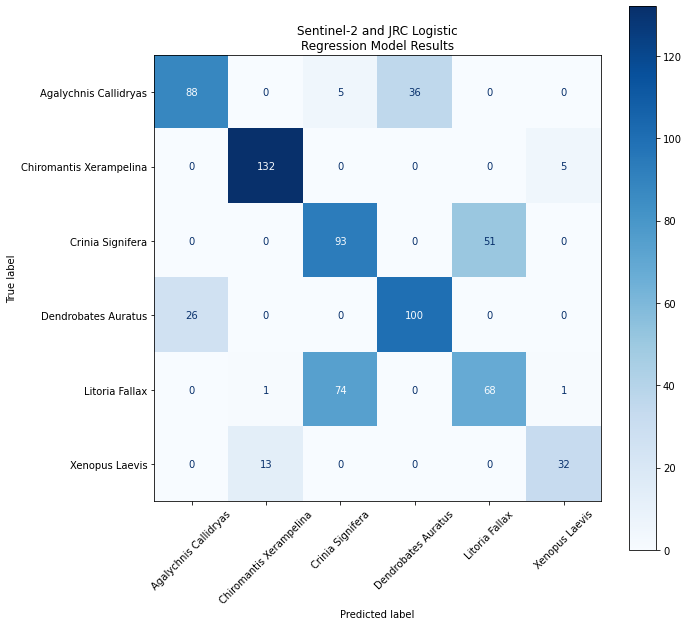

In [21]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, cmap='Blues')
disp.figure_.set_size_inches((10, 10))
disp.ax_.set_title('Sentinel-2 and JRC Logistic\nRegression Model Results')
plt.xticks(rotation=45)
plt.show()

#### Out-of-sample evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use K-fold cross-validation, although there are many other techniques available. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 values which can be averaged, giving a more reliable and valid measure of model performance. 

`Scikit-learn` has built-in functions that can assist in K-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frog species in each fold.


In [22]:
from sklearn.model_selection import StratifiedKFold

cv_model = LogisticRegression() 

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
metric_params = {'F1': {'average':'macro'}, 'Accuracy': {}}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions, **metric_params[metric]))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.7
Accuracy: 0.69


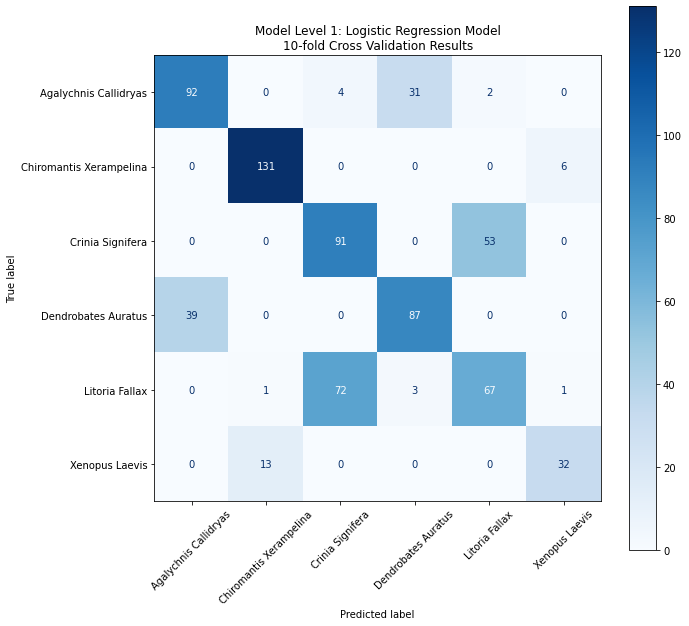

In [23]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], cmap='Blues')
disp.figure_.set_size_inches((10, 10))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.xticks(rotation=45)
plt.show()

## Model Visualisation

Now that we have evaluated our model on the training set, it might be useful to visualise the species distribution model over the training regions or any arbitrary area. To do this, we will generate a probability heatmap of the entire region rather than just the points from the training set. 

When we consider an entire satellite image with dimensions $(m, n)$, we say the model will take in a $p$ band image with dimensions $(p, m, n)$ containing the predictor values for each pixel, and will output a $k$ band image with dimensions $(k, m, n)$ containing the probabilities of each. More formally, we have:
$$
X_{(p, m, n)}  \xrightarrow{\text{model}} P_{(k, m, n)}
$$

Put simply, our model will take in a $p$ banded predictor image and output a $k$ banded probability image. 


To do this, we need to write some functions that will allow us to automatically pull the required data to generate $X$ for an arbitrary location. Specifically, we need to be able to pull all the predictor variables for a given location, as well as the actual frog sightings in that location for reference. Then we will run the model over $X$ to output $P$. Finally, we can produce a probability heatmap for each band/species in image $P$, which will show regions that our model thinks are likely frog habitats for each species - known as a species distribution model (SDM). 


We will visualise one training region (Port Macquarie, NSW) defined in the `training_regions` variable. To visualise the other two training regions, simply comment out the 'if' statement marked with a comment below. Additionally, you may wish to visualise an arbitrary bounding


In [24]:
# Collect frogs for each region for visualisation
for key, regions in training_regions.items():
    # Only visualise Port Macquarie
    if key != 'Australia':
        continue
    print(key)
    for region in regions:
        region['frogs'] = get_frogs(data_path+'/training_data/occurrence.txt', bbox=region['bbox'])

Australia


### Writing and reading GeoTIFF files
Creating the predictor images over an entire region can be quite memory intensive and time consuming. Below, we define a function that will save an xarray object to a geotiff. The bands are saved to a separate text file, so will need to be loaded in separately.

In [25]:
def save_to_geotiff(arr, filename, bbox, dtype='uint8', verbose=False):
    # If filename is specified, save mosaic to geotiff  
    bands = arr.shape[0]
    height = arr.shape[1]
    width = arr.shape[2]
        
    # write bandnames to separate file
    with open(filename+'.bands', 'w') as file:
        file.write(','.join(arr.band.values))
        
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
    # Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
    gt = rasterio.transform.from_bounds(min_lon, min_lat, max_lon, max_lat, width, height)
    arr.rio.write_crs("epsg:4326", inplace=True)
    arr.rio.write_transform(transform=gt, inplace=True);
    
    # Create the GeoTIFF output file using the defined parameters
    with rasterio.open(filename+'.tiff', 'w', driver='GTiff', width=width, height=height, crs='epsg:4326',
                       transform=gt, count=bands, compress='lzw', dtype=dtype) as dst:
        for band in range(bands):
            print(f'writing {band+1} of {bands}') if verbose else None
            dst.write(arr[band],band+1)
        dst.close()
        
def load_geotiff(filename):
    """Provide full path filename without file extension!"""
    with open(f"{filename}.bands", 'r') as band_file:
        bands = band_file.readline().split(',')
    return xr.open_rasterio(f"{filename}.tiff").assign_coords(band=bands)
    

Now, we write our function to create the predictor images for each region. It is somewhat similar to the previous load function.

In [26]:
def create_predictor_image(products, bbox, model_features, split_sen=(1, 1), verbose=False):
    """collect and download all products"""
    # Define categorical mappings
    landcover_mapper = {
        1:'lc_water', 2:'lc_trees', 3:'lc_grass',4:'lc_flooded_vegetation', 5:'lc_crops',
        6:'lc_scrub', 7:'lc_urban', 8:'lc_bare_soil',9:'lc_snow_ice', 10:'lc_clouds'
    }
    JRC_transitions_mapper = {
        1:"JRC_tr_permanent", 2:"JRC_tr_new_permanent", 3:"JRC_tr_lost_permanent",
        4:"JRC_tr_seasonal", 5:"JRC_tr_new_seasonal",6:"JRC_tr_lost_seasonal",
        7:"JRC_tr_seasonal_to_permanent", 8:"JRC_tr_permanent_to_seasonal", 
        9:"JRC_tr_ephemeral_permanent", 10:"JRC_tr_ephemeral_seasonal"
    }
    predictor_image = None
    for i, (product, params) in enumerate(products.items()):
        print(f'loading {product}') if verbose else None
        
        # Interpolate the weather data to 10m resolution
        if product == 'terraclimate':
            if i == 0:
                print("Cannot load TerraClimate first")
                return
            data = get_terraclimate(bbox, verbose=False, **params)
        elif product == 'sentinel-2-l2a':
            data = None
            for box_num, box in enumerate(split_bbox(bbox, split_sen[0], split_sen[1])):
                print(f'fetching box {box_num+1} of {split_sen[0]*split_sen[1]}') if verbose else None
                if data is None:
                    data = get_pc(product, box, verbose=verbose, **params).rename('sentinel-2')
                else:
                    data = xr.merge(
                        (get_pc(product, box, verbose=verbose, **params).rename('sentinel-2'), data),
                        join='outer', compat='override'
                    )
            if split_sen != (1, 1):
                data = data.to_array().squeeze()
        else:
            data = get_pc(product, bbox, verbose=False, **params)
            
        # Calculate the gradient of the elevation data
        if product == 'cop-dem-glo-30':
            data_elevation = data.squeeze().drop("band")
            slope_vals = slope_pct(data_elevation, products[product]['resolution'])
            data_slope = xr.DataArray(
                np.expand_dims(slope_vals, 0),
                coords=dict(
                    band=['gradient'],
                    y=data_elevation.y,
                    x=data_elevation.x
                )
            )
            data = data.assign_coords(band=['elevation'])
            data = xr.concat((data, data_slope), dim='band')
            # remove elevation data from memory
            del data_slope, data_elevation, slope_vals
        # one-hot encoding for landcover and JRC
        elif product == 'io-lulc':
            one_hot_data = None
            for i in range(1, 11):
                if landcover_mapper[i] in model_features:
                    if one_hot_data is None:
                        one_hot_data = (data == i).assign_coords(band=[landcover_mapper[i]])
                    else:
                        one_hot_data = xr.concat((one_hot_data, (data == i).assign_coords(band=[landcover_mapper[i]])), dim='band')
            data = one_hot_data
            del one_hot_data       
        elif product == 'jrc-gsw':
            one_hot_data = None
            for i in range(1, 11):
                if JRC_transitions_mapper[i] in model_features:
                    if one_hot_data is None:
                        one_hot_data = (data.sel(band='transitions') == i).expand_dims('band').assign_coords(band=[JRC_transitions_mapper[i]])
                    else:
                        one_hot_data = xr.concat((one_hot_data, (data.sel(band='transitions') == i).expand_dims('band').assign_coords(band=[JRC_transitions_mapper[i]])), dim='band')
            data = xr.concat((data.drop('transitions', dim='band'), one_hot_data), dim='band')
            
        if predictor_image is None:
            predictor_image = data.rename('value')
        else:
            data = data.reset_coords(drop=True)
            data_shape = (len(data.x), len(data.y))
            pred_shape = (len(predictor_image.x), len(predictor_image.y))
            
            if data_shape != pred_shape:
                data = data.interp(x=predictor_image.x.values, y=predictor_image.y.values, method='nearest', kwargs={"fill_value": "extrapolate"})
                data = data.sel(x=predictor_image.x.values, y=predictor_image.y.values)
            
            predictor_image = xr.concat(
                (predictor_image, data), dim='band', join='override'
            )
            
    # Reorder bands
    ordered_predictors = None
    for x_band in model_features:
        if ordered_predictors is None:
            ordered_predictors = predictor_image.sel(band=x_band)
        else:
            ordered_predictors = xr.concat((ordered_predictors, predictor_image.sel(band=x_band)), dim="band", join='override')        
    # Check all match
    print("All match: ", np.all(ordered_predictors.band.values == model_features)) if verbose else None
    
        
    return predictor_image

**Tip:** Obtaining the predictor data for each region is quite time consuming. Running the code below for the first time will take up to about 10 minutes. Once the predictor image has been created and saved, you can comment out the `create_predictor_image` call and simply load in the image from file. This is much quicker. 

With these long load times in mind, you might think how to better create your data pipeline to avoid as much i/o as possible. For example, saving all raw data to geotiff first and then reading it in from file at the top of your pipeline will likely save you a lot of compute time on each iteration of your model. 

In [27]:
%%time
for cnt, regions in training_regions.items():
    # Only visualise Port Macquarie
    if cnt != 'Australia':
        continue
    print(f"Obtaining data for {cnt}")
    for i, region in enumerate(regions):
        print(f"{region['title']} ({i+1} of {len(regions)})")
        
        # Run once and comment out after
        region['predictor'] = create_predictor_image(products, region['bbox'], full_model.feature_names_in_, split_sen=(1, 1), verbose=True)
        save_to_geotiff(region['predictor'].compute(), f'{storage_path}{cnt}_{i+1}', region['bbox'], dtype='uint16', verbose=True)
        
        # Read in predictors from file
        region['predictor'] = load_geotiff(f'{storage_path}{cnt}_{i+1}')
        display(region['predictor'])
        gc.collect()

Obtaining data for Australia
Port Macquarie, Australia (1 of 1)
loading io-lulc
loading cop-dem-glo-30
loading jrc-gsw
loading sentinel-2-l2a
fetching box 1 of 1
446 scenes touching region
Covered 100.0% with 3 scenes
Searched 104 scenes
loading terraclimate
All match:  True
writing 1 of 30
writing 2 of 30
writing 3 of 30
writing 4 of 30
writing 5 of 30
writing 6 of 30
writing 7 of 30
writing 8 of 30
writing 9 of 30
writing 10 of 30
writing 11 of 30
writing 12 of 30
writing 13 of 30
writing 14 of 30
writing 15 of 30
writing 16 of 30
writing 17 of 30
writing 18 of 30
writing 19 of 30
writing 20 of 30
writing 21 of 30
writing 22 of 30
writing 23 of 30
writing 24 of 30
writing 25 of 30
writing 26 of 30
writing 27 of 30
writing 28 of 30
writing 29 of 30
writing 30 of 30


<xarray.DataArray (band: 30, y: 558, x: 558)>
[9340920 values with dtype=uint16]
Coordinates:
  * band     (band) <U28 'lc_water' 'lc_trees' ... 'ppt_mean' 'soil_mean'
  * y        (y) float64 -31.4 -31.4 -31.4 -31.4 ... -31.9 -31.9 -31.9 -31.9
  * x        (x) float64 152.4 152.4 152.4 152.4 ... 152.9 152.9 152.9 152.9
Attributes:
    transform:      (0.0008960573476702509, 0.0, 152.4, 0.0, -0.0008960573476...
    crs:            +init=epsg:4326
    res:            (0.0008960573476702509, 0.0008960573476702509)
    is_tiled:       0
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area

CPU times: user 7.45 s, sys: 651 ms, total: 8.11 s
Wall time: 58.8 s


Once our predictor images are loaded, we can use our model to create the resultant probability predictions.

In [28]:
# Helper function to assist with memory - sometimes predicting the entire scene at once crashes the kernel
def predict_in_batches(predictor_image, model, batches=10):
    probabilities = np.zeros((predictor_image.shape[0], len(model.classes_)))
    offset=0
    for batch in np.array_split(predictor_image,batches):
        probabilities[offset:(offset+batch.shape[0])] = model.predict_proba(
            batch
        )
        offset += batch.shape[0]
    return probabilities

def predict_frogs(predictor_image, model):
    """Returns a (k, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Take only bands in model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), len(model.classes_)))
    # Calculate probability for each non-null pixel point (in batches to preserve memory)
    probabilities[~null_pixels] = predict_in_batches(predictor_image[~null_pixels], model, batches=10)
    probabilities[null_pixels] = np.array([np.nan]*len(model.classes_))
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z', 'band'],
        coords=dict(
            z=predictor_image.z,
            band=model.classes_
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [29]:
%%time
for cnt, regions in training_regions.items():
    # Only visualise Port Macquarie
    if cnt != 'Australia':
        continue
    print(f"Obtaining data for {cnt}")
    for i, region in enumerate(regions):
        print(f"{region['title']} ({i+1} of {len(regions)})")
        
        # Run once and comment out after
        region['result'] = predict_frogs(region['predictor'], full_model) 
        save_to_geotiff(region['result'], f'{storage_path}{cnt}_{i+1}_result', region['bbox'], dtype='float32', verbose=False)
        
        # Load from file
        region['result'] = load_geotiff(f'{storage_path}{cnt}_{i+1}_result')
        display(region['result'])

Obtaining data for Australia
Port Macquarie, Australia (1 of 1)


<xarray.DataArray (band: 6, y: 558, x: 558)>
[1868184 values with dtype=float32]
Coordinates:
  * band     (band) <U23 'Agalychnis Callidryas' ... 'Xenopus Laevis'
  * y        (y) float64 -31.4 -31.4 -31.4 -31.4 ... -31.9 -31.9 -31.9 -31.9
  * x        (x) float64 152.4 152.4 152.4 152.4 ... 152.9 152.9 152.9 152.9
Attributes:
    transform:      (0.0008960573476702509, 0.0, 152.4, 0.0, -0.0008960573476...
    crs:            +init=epsg:4326
    res:            (0.0008960573476702509, 0.0008960573476702509)
    is_tiled:       0
    nodatavals:     (nan, nan, nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

CPU times: user 442 ms, sys: 377 ms, total: 819 ms
Wall time: 348 ms


Now we have our model's probability distribution for each species, it is time to visualise this. The function below takes in the multi-band probability image and displays it as a heatmap, as well as a binary mask of where that species had the highest probability of occurring.

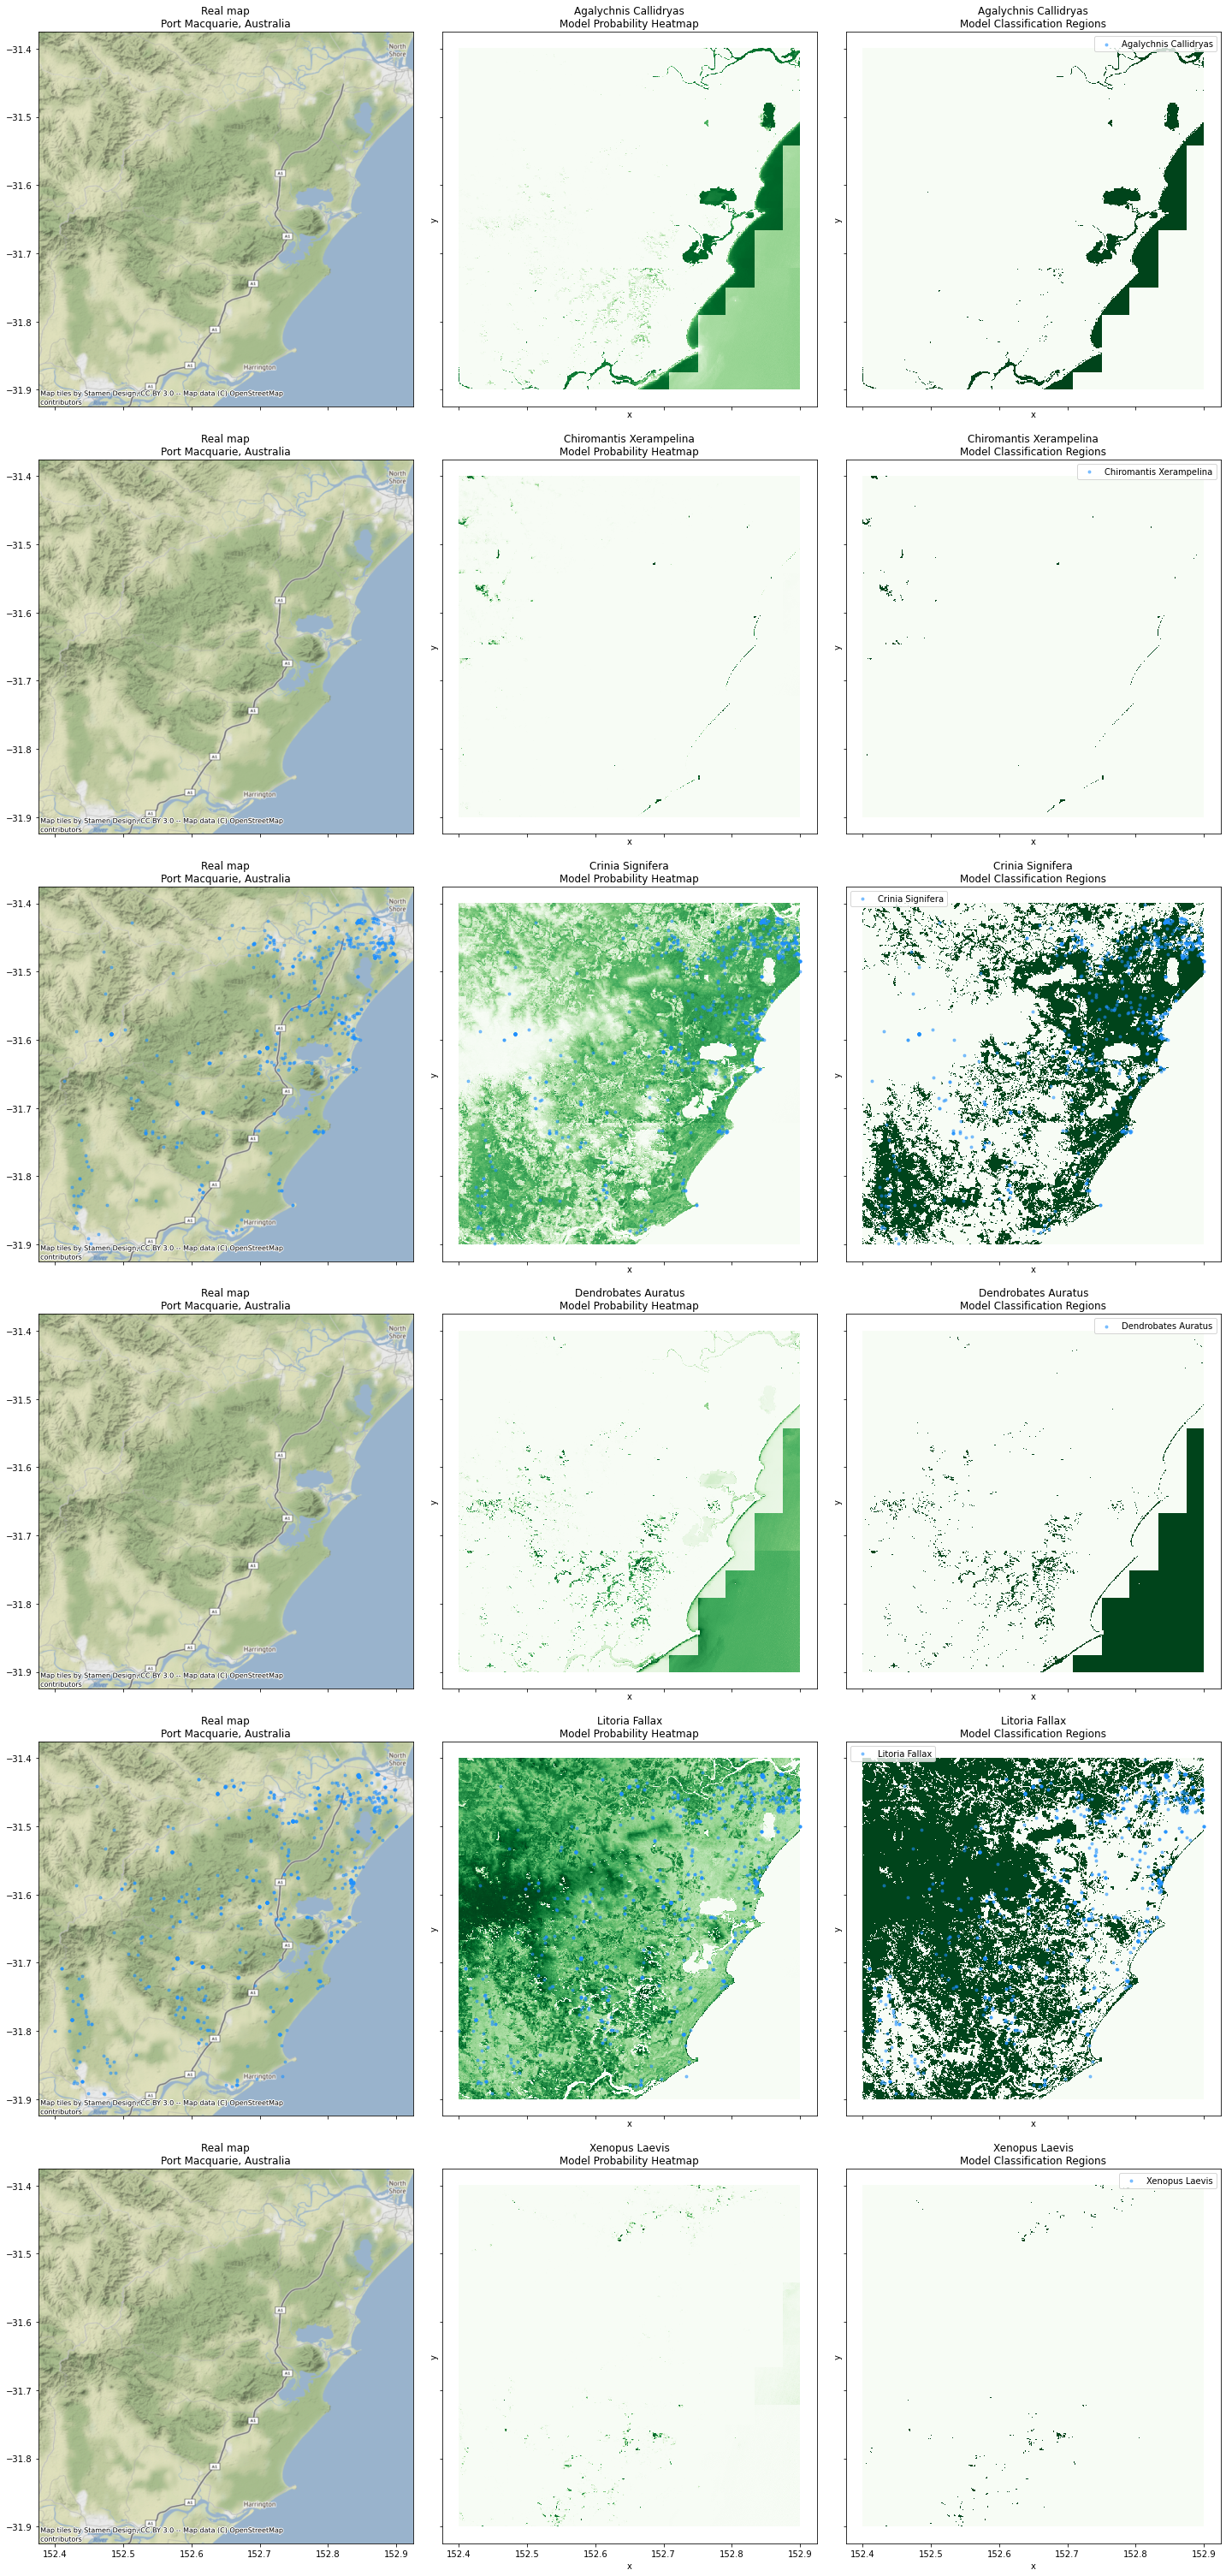

In [30]:
def plot_heatmap(resultant_image, species_names, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(len(species_names), 3, figsize=(20, 7*len(species_names)), sharey=True, sharex=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    max_val = resultant_image.values.max()
    min_val = resultant_image.values.min()
    cmap = 'Greens'
    regions_image = resultant_image.argmax(dim='band')
    for i, species in enumerate(species_names):
        species_plot = resultant_image.sel(band=species)
        # Plot real map
        ax[i, 0].scatter(
            x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0
        )
        cx.add_basemap(ax[i, 0], crs=crs)
        ax[i, 0].set_title(f'Real map\n{title}')        
        # Plot heatmap from model
        heatmap = species_plot.plot.imshow(
            x='x', y='y', ax=ax[i, 1], cmap=cmap, vmin=min_val, vmax=max_val, interpolation='none', add_colorbar=False
        )
        ax[i, 1].set_aspect('equal')
        ax[i, 1].set_title(f'{species}\nModel Probability Heatmap')
        # Plot binary classification from model
        regions = xr.where(regions_image.isnull(),np.nan, regions_image==i).plot.imshow(
            x='x', y='y', ax=ax[i, 2], cmap=cmap, vmin=min_val, vmax=max_val, interpolation='none', add_colorbar=False
        )
        ax[i, 2].set_aspect('equal')
        ax[i, 2].set_title(f'{species}\nModel Classification Regions')
        # Plot real frogs
        for j in range(3):
            filt = frog_data.species == species
            ax[i, j].scatter(
                frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
                color = 'dodgerblue', marker='.', alpha=0.5, label=species if j==2 else ''
            )
        ax[i, 2].legend()
    # fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    # fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    fig.tight_layout()
    plt.show()
    
for key, regions in training_regions.items():
    if key != 'Australia':
        continue
    for region in regions:
        plot_heatmap(region['result'], region['result'].band.values, region['frogs'], f"{region['title']}")

## Submission

Once you are happy with your model's performance, it will come time to run your model over the test regions and make predictions for the set of test coordinates. Below, we have defined the test regions in a similar format to the training regions above. The set of test coordinates are specified in 'challenge_2_submission_template.csv'.

**Tip:** As I'm sure you have already discovered, it takes quite a long time to collect the predictor images for a given region.  For this reason, we recommend saving the raw data that your model will use in GeoTIFF format for each of the test regions, and then performing relevant feature engineering after reading in the raw files. Taking this approach to your data pipeline will quicken the submission process to improve the turn around of each model iteration.

In [31]:
test_file = pd.read_csv('challenge_2_submission_template.csv')

In [32]:
# Read in test regions
test_2_regions = []
with open('challenge_2_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_2_regions.append(eval("("+line+")"))

The following will create our predictor images and run our model over just 3 of the 12 test regions. This will save on time for demonstration purposes. To run on all 12 regions, simply comment out the 'if' statements at the top of the loops. Each predictor image is saved to a geotiff and read back in. Upon running this code the first time, it can take a while to fetch and save each predictor image. In the case that a runtime error stops your progress, we recommend you alter the `start_from_region` variable to the region that threw the error before retrying the code. This will allow you to skip the regions you have already loaded in. Note that  regions are numbered starting from 1.

In [33]:
%%time

start_from_region = 1

test_regions = {}
for i, box in enumerate(test_2_regions):
    # Take first three regions
    if i >= 3:
        continue
    print(f'Running on test region {i+1}')
    test_regions[i] = {'bbox': box}
    print('Getting locations')
    test_regions[i]['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], test_regions[i]['bbox'])
    
    print('Getting predictors')
    if (i+1) >= start_from_region:
        test_regions[i]['predictor'] = create_predictor_image(products, test_regions[i]['bbox'], full_model.feature_names_in_, split_sen=(1, 1), verbose=True)
        # Try again at most 3 times if runtime error occurs.
        for j in range(3):
            try:
                save_to_geotiff(test_regions[i]['predictor'].compute(), f'{storage_path}test_{i+1}_preds', test_regions[i]['bbox'], dtype='uint16', verbose=True)
                break
            except RuntimeError:
                print(f'Runtime error {j+1} saving region {i+1}')
                continue
    
    test_regions[i]['predictor'] = load_geotiff(f'{storage_path}test_{i+1}_preds')
    
    print('Running model')
    test_regions[i]['result'] = predict_frogs(test_regions[i]['predictor'], full_model) 
    save_to_geotiff(test_regions[i]['result'].compute(), f'{storage_path}test_{i+1}_result', test_regions[i]['bbox'], dtype='float32', verbose=True)

    test_regions[i]['result'] = load_geotiff(f'{storage_path}test_{i+1}_result')

Running on test region 1
Getting locations
Getting predictors
loading io-lulc
loading cop-dem-glo-30
loading jrc-gsw
loading sentinel-2-l2a
fetching box 1 of 1
480 scenes touching region
Covered 100.0% with 10 scenes
Searched 241 scenes
loading terraclimate
All match:  True
writing 1 of 30
writing 2 of 30
writing 3 of 30
writing 4 of 30
writing 5 of 30
writing 6 of 30
writing 7 of 30
writing 8 of 30
writing 9 of 30
writing 10 of 30
writing 11 of 30
writing 12 of 30
writing 13 of 30
writing 14 of 30
writing 15 of 30
writing 16 of 30
writing 17 of 30
writing 18 of 30
writing 19 of 30
writing 20 of 30
writing 21 of 30
writing 22 of 30
writing 23 of 30
writing 24 of 30
writing 25 of 30
writing 26 of 30
writing 27 of 30
writing 28 of 30
writing 29 of 30
writing 30 of 30
Running model
writing 1 of 6
writing 2 of 6
writing 3 of 6
writing 4 of 6
writing 5 of 6
writing 6 of 6
Running on test region 2
Getting locations
Getting predictors
loading io-lulc
loading cop-dem-glo-30
loading jrc-gsw
loa

### Preparing submission file

Once we have made prediction images for each of the training regions, we can curate our submission file. Firstly, we need to generate a boolean mask for each region.

In [34]:
for key, region in test_regions.items():
    if key >= 3:
        continue
    cont_submission = None
    for species in list(test_file.drop(['id', 'decimalLongitude', 'decimalLatitude'], 1).columns):
        if species in region['result'].band.values:
            if cont_submission is None:
                cont_submission = region['result'].sel(band=species)
            else:
                cont_submission = xr.concat((cont_submission, region['result'].sel(band=species)), dim='band')
        else:
            if cont_submission is None:
                cont_submission = xr.zeros_like(region['result'][0]).assign_coords(band=species)
            else:
                cont_submission = xr.concat((cont_submission, xr.zeros_like(region['result'][0]).assign_coords(band=species)), dim='band')

    # Make binary mask
    binary_submission = None
    argmax_image = cont_submission.argmax(dim='band')
    for i, band in enumerate(cont_submission.band.values):
        if binary_submission is None:
            binary_submission = (argmax_image == i).assign_coords(band=band).astype(bool)
        else:
            binary_submission = xr.concat(
                (binary_submission, (argmax_image == i).assign_coords(band=band).astype(bool)), dim='band'
            )

    region['bin_submission'] = binary_submission

Then we can lookup the values from this boolean mask for each of the coordinates specified in 'challenge_2_submission_template.csv', outputting the model's predictions in one-hot encoding in a file titled 'challenge_2_submission_benchmark.csv'. This is the file you will upload to the portal to obtain your score.

In [35]:
predictions = pd.DataFrame()
for key, region in test_regions.items():
    # Take first three regions
    if key >= 3:
        continue
    preds = (
        region['bin_submission'].rename('presence')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .pivot(index=["id", "x", "y"], columns="band", values="presence")
        .reset_index()
        .melt(id_vars=["id", "x", "y"], var_name='species')
        [lambda x: x.value == 1]
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
        .drop('value', 1)
    )
    preds = preds.join(
        pd.get_dummies(preds.species)
    ).drop('species', 1)
    predictions = predictions.append(preds)            

submission = (
    test_file
    .merge(
        predictions, 
        on='id',
        how='left', suffixes = ('_', '')
    )
    .assign(
        decimalLatitude = lambda x: np.where(x.decimalLatitude.isna(), x.decimalLatitude_, x.decimalLatitude),
        decimalLongitude = lambda x: np.where(x.decimalLongitude.isna(), x.decimalLongitude_, x.decimalLongitude)
    )
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)

submission.to_csv('challenge_2_submission_benchmark.csv', index=None)

### Get Frogging!

Now that you have witnessed our benchmark approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to add a few more training regions to include the three missing Australian species, or alter the resolution of the model.

Be sure to address some of the assumptions made here, particularly ways to address the following five issues we identified:
- Spatial sampling - choosing more regions that are representative of the entire dataset.
- Sampling bias - developing a smart way to address the dataset's bias towards urban areas.
- Class balancing - smarter up-sampling and down-sampling methods using techniques like data augmentation to increase the representation of rarer species. 
- Temporal sampling - considering the temporal component of the dataset. Which older points are still relevant, and which may not be?

You might even decide on a completely different training set, such as classifying regions rather than points. Once these issues with the training set are addressed, you should begin to think about which machine learning approach would be most appropriate, logistic regression was just one idea. We suggest you try different approaches and see what works.

Due to the computational requirements of this challenge, we recommend you spend some time planning your data pipeline. Try and minimise calls to the planetary computer by saving raw data from both the training and test set to file, then process the raw data from file. This will greatly reduce the time required to make a submission. 

Ultimately, do whatever you think will create the best model for predicting the frog habitats of the species of interest. Happy frogging!